<font size="5">Procesar imagenes ABI y seguir un sistema de nubes en el tiempo. Extraer informaciones globales como Areas de lluvia fuerte y débil</font>

### Tormenta a procesar:
Inicio: 13/03/2023 21 UTC

Fin:    14/03/2023 15 UTC

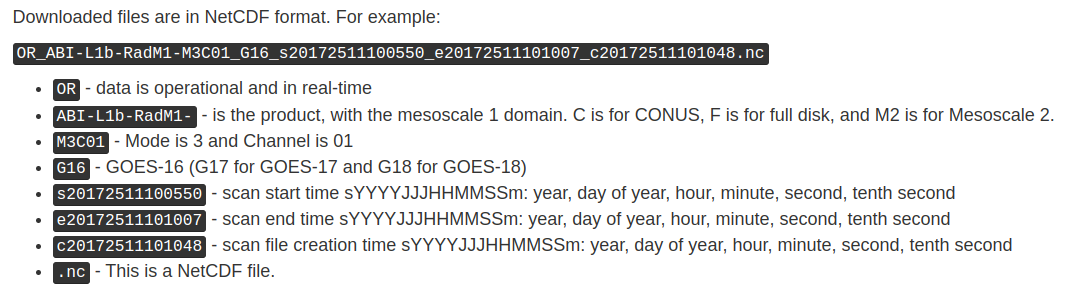

In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
import matplotlib

from netCDF4 import Dataset
import cartopy.crs as ccrs  # Plot maps
import os
import sys

from util_imag_2023 import *


# Función de realce lineal al p porciento
def realce(vec, p=2, gamma=1):
    aux = np.sort(vec.flatten())
    imin = int(len(aux) * p / 100)
    imax = int(len(aux) * (100 - p) / 100)
    vmin = float(aux[imin])
    vmax = float(aux[imax])
    rimag = ( (vec - vmin) / (vmax - vmin) )**gamma
    rimag[rimag < 0] = 0
    rimag[rimag > 1] = 1
    return rimag

def pca(X):
    '''
    Obtiene la descomposición PCA de una imagen de entrada.
    
    Parámetros
    ----------
    X : numpy.array
        Imagen de entrada cuyas dimensiones son [filas, columnas, bandas].
    
    Retornos
    --------
    x_pca : numpy.array
        Array con las componentes principales cuyas dimensiones
        son [filas*columnas, bandas].
    eigen_vals : numpy.array
        Array con los eigen values. 
    eigen_vecs : numpy.array
        Array con los eigen vectors.
    '''
    # Obtenemos las dimensiones
    filas, columnas, bandas = X.shape
    # Reacomodamos la matriz a 2 dimensiones
    xr = np.reshape(X, [filas * columnas, bandas])
    # Centro los datos
    xr = xr - xr.mean(axis=0)
    # Calculamos la matriz de covarianza
    C = np.dot(xr.T, xr) / (filas * columnas - 1)
    # Realizamos la descomposición
    eigen_vals, eigen_vecs = np.linalg.eig(C)
    X_pca = np.dot(xr, eigen_vecs)
    return X_pca, eigen_vals, eigen_vecs

# Esta parte es para cargar todas las imagenes de una misma banda

In [3]:
dir_nc = '/home/msuarez/GOES_16_TF/14032023/CH14/'

Filelist = glob.glob(dir_nc+'*.nc')
Filelist.sort()
Filelist

['/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730000205_e20230730009517_c20230730009565.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730030205_e20230730039514_c20230730039563.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730100205_e20230730109514_c20230730109582.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730130205_e20230730139514_c20230730139574.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730200205_e20230730209514_c20230730209575.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730230205_e20230730239514_c20230730239554.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730300205_e20230730309514_c20230730309568.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730330205_e20230730339514_c20230730339573.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14

In [3]:
#img_list_import = [Filelist[5],Filelist[12],Filelist[13],Filelist[16]]

#print('Lista de imagenes a importar:\n')
#for i in range(len(img_list_import)): print(img_list_import[i])

In [4]:
#imagenobj_list = []
#print('Importando imagenes...')
#for i in range(len(img_list_import)): imagenobj_list.append(Dataset(img_list_import[i], 'r'))
#print('Imagenes importadas en la lista imagenobj_list.')

In [5]:
#imagenobj_list[0].variables.keys()

In [4]:
import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')

In [10]:
import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (1.0, 0.0, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')


bounds = [0,0.1,20,100]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# Intento primero recortar y despues calibrar las imagenes de la misma banda

In [5]:
imagenobj_list = []
print('Importando imagenes...')
for i in range(len(Filelist)): imagenobj_list.append(Dataset(Filelist[i], 'r'))
print('Imagenes importadas en la lista imagenobj_list.')

metadato_list = [imagenobj_list[i].variables for i in range(len(Filelist))]

# Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
# Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
# respectivamente, de forma tal de obtener el mismo recorte
sup_row = 4000
inf_row = 5000
sup_col = 2500
inf_col = 3600

print('Tamaño del recorte: Alto=',inf_row-sup_row,' Ancho=',inf_col-sup_col)

imagen_list = []
imag_cal_list = []

for metadato in metadato_list:
    
    try:
        # altura de la orbita del satelite en metros (35786023.0)
        altura=metadato['goes_imager_projection'].perspective_point_height
        # 6378137.0 semieje mayor en metros
        semieje_may=metadato['goes_imager_projection'].semi_major_axis
        # 6356752.31414 semieje menor en metros
        semieje_men=metadato['goes_imager_projection'].semi_minor_axis
        # -75 longitud central
        lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

        #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
        img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
        pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
        ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

        icanal = int(metadato['band_id'][:])
        print ('Procesando Canal %d' %icanal)
        #print('pol',pol,' ecu',ecu)
        ####################################################################################################
        imagen = metadato['Rad'][:].data
        print('Tamaño original de la imagen:',imagen.shape)
        print('Recortando imagen')
        # Bandas de 1 km de resolución espacial
        if (icanal == 1) or (icanal == 3) or (icanal == 5):
            print('entra al if 1,3,5')
            imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
        # Bandas de 0.5 km de resolución espacial
        elif icanal == 2:
            print('entra al elif 2')
            imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
        # Bandas de 2 km de resolución espacial
        else:
            print('entra al else')
            imagen = imagen[sup_row:inf_row,sup_col:inf_col]
        ####################################################################################################
        if icanal >7:
            print ('Calibrando la imagen (if)')
            #Parámetros de calibracion
            fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
            fk2 = metadato['planck_fk2'][0] # (=1497.61)
            bc1 = metadato['planck_bc1'][0] # (=0.09102)
            bc2 = metadato['planck_bc2'][0] # (=0.99971)

            imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
            imag_cal_list.append(imag_cal)
            # imag_cal es un array de (5424, 5424)
            Unit = "Temperatura de Brillo [°C]"
        else:
            print ('Calibrando la imagen (else)')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset
            imag_cal =imagen*pendiente+ordenada
            imag_cal_list.append(imag_cal)
            Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    except:
        print('Se ingresó al bloque except!')
        continue
        
    print('\n') 

Importando imagenes...
Imagenes importadas en la lista imagenobj_list.
Tamaño del recorte: Alto= 1000  Ancho= 1100
Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tama

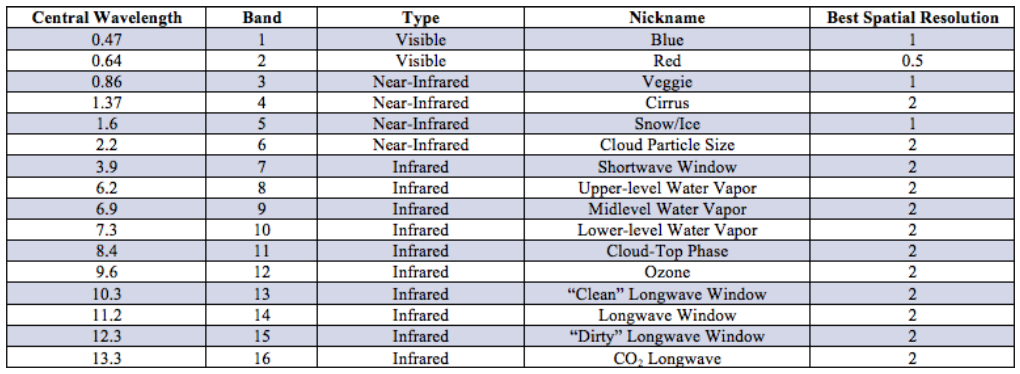

# Graficamos todos los plots de la misma banda cargados anteriormente

In [ ]:
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(13, 13))
ax = ax.ravel()

for i in range(len(imag_cal_list)):
    im = ax[i].imshow(imag_cal_list[i], cmap='jet')
    ax[i].set_title('Banda '+str(metadato_list[i]['band_id'][:]))
    ax[i].set_xticklabels('')
    ax[i].set_yticklabels('')
    fig.colorbar(im, shrink=.5, ax=ax[i])
    
plt.tight_layout()
plt.show()

# Esto es para ver el tema del recorte

In [ ]:
img = Dataset(path+'CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730000205_e20230730009517_c20230730009565.nc', 'r')

metadato = img.variables

sup_row = 4200
inf_row = 4600
sup_col = 2900
inf_col = 3300

# True para recortar
recortar = False

# altura de la orbita del satelite en metros (35786023.0)
altura=metadato['goes_imager_projection'].perspective_point_height
# 6378137.0 semieje mayor en metros
semieje_may=metadato['goes_imager_projection'].semi_major_axis
# 6356752.31414 semieje menor en metros
semieje_men=metadato['goes_imager_projection'].semi_minor_axis
# -75 longitud central
lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

#img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

icanal = int(metadato['band_id'][:])
print ('Procesando Canal %d' %icanal)
#print('pol',pol,' ecu',ecu)
####################################################################################################
imagen = metadato['Rad'][:].data
print('Tamaño original de la imagen:',imagen.shape)

if recortar:
    print('Recortando imagen')
    # Bandas de 1 km de resolución espacial
    if (icanal == 1) or (icanal == 3) or (icanal == 5):
        print('entra al if 1,3,5')
        imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
    # Bandas de 0.5 km de resolución espacial
    elif icanal == 2:
        print('entra al elif 2')
        imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
    # Bandas de 2 km de resolución espacial
    else:
        print('entra al else')
        imagen = imagen[sup_row:inf_row,sup_col:inf_col]
else:
    print('No se recorta imagen')
    
    
    
if icanal >7:
    print ('Calibrando la imagen (if)')
    #Parámetros de calibracion
    fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
    fk2 = metadato['planck_fk2'][0] # (=1497.61)
    bc1 = metadato['planck_bc1'][0] # (=0.09102)
    bc2 = metadato['planck_bc2'][0] # (=0.99971)

    imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
    # imag_cal es un array de (5424, 5424)
    Unit = "Temperatura de Brillo [°C]"
else:
    print ('Calibrando la imagen (else)')
    pendiente= metadato['Rad'].scale_factor
    ordenada= metadato['Rad'].add_offset
    imag_cal =imagen*pendiente+ordenada
    Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    
    
plt.imshow(imag_cal,vmin=-100,vmax=30, cmap='jet')
plt.plot([sup_col,inf_col],[sup_row,sup_row], color='black')
plt.plot([sup_col,inf_col],[inf_row,inf_row], color='black')
plt.plot([inf_col,inf_col],[inf_row,sup_row], color='black')
plt.plot([sup_col,sup_col],[inf_row,sup_row], color='black')

plt.show()

In [ ]:
plt.figure()
#proyeccion geoestacionaria para Goes16
crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura)
ax = plt.axes(projection=crs)
ax.gridlines() #agrega linea de meridianos y paralelos
ax.coastlines(resolution='10m',color='blue') #agrega líneas de costa

img=plt.imshow(imag_cal,extent=img_extent,vmin=-100.,vmax=30.,cmap='jet')
# Add a colorbar
#plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='vertical',pad=0.05, fraction=0.05)

plt.show()

# Aca se cargan todas las bandas del mismo t

In [8]:
path = '/home/msuarez/GOES_16_TF/14032023/'


list_imgs = ['CH08/OR_ABI-L1b-RadF-M6C08_G16_s20230730000205_e20230730009513_c20230730009575.nc',
             'CH09/OR_ABI-L1b-RadF-M6C09_G16_s20230730000205_e20230730009519_c20230730009581.nc',
             'CH10/OR_ABI-L1b-RadF-M6C10_G16_s20230730000205_e20230730009525_c20230730009554.nc',
             'CH11/OR_ABI-L1b-RadF-M6C11_G16_s20230730000205_e20230730009514_c20230730009568.nc',
             'CH12/OR_ABI-L1b-RadF-M6C12_G16_s20230730000205_e20230730009519_c20230730009573.nc',
             'CH13/OR_ABI-L1b-RadF-M6C13_G16_s20230730000205_e20230730009525_c20230730009576.nc',
             'CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730000205_e20230730009517_c20230730009565.nc',
             'CH15/OR_ABI-L1b-RadF-M6C15_G16_s20230730000205_e20230730009523_c20230730009571.nc',
             'CH16/OR_ABI-L1b-RadF-M6C16_G16_s20230730000205_e20230730009529_c20230730009560.nc']

#list_imgs = ['CH08/OR_ABI-L1b-RadF-M6C08_G16_s20230730200205_e20230730209513_c20230730209575.nc',
#             'CH09/OR_ABI-L1b-RadF-M6C09_G16_s20230730200205_e20230730209519_c20230730209566.nc',
#             'CH10/OR_ABI-L1b-RadF-M6C10_G16_s20230730200205_e20230730209525_c20230730209573.nc',
#             'CH11/OR_ABI-L1b-RadF-M6C11_G16_s20230730200205_e20230730209513_c20230730209559.nc',
#             'CH12/OR_ABI-L1b-RadF-M6C12_G16_s20230730200205_e20230730209519_c20230730209581.nc',
#             'CH13/OR_ABI-L1b-RadF-M6C13_G16_s20230730200205_e20230730209527_c20230730209583.nc',
#             'CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730200205_e20230730209514_c20230730209575.nc',
#             'CH15/OR_ABI-L1b-RadF-M6C15_G16_s20230730200205_e20230730209520_c20230730209578.nc',
#             'CH16/OR_ABI-L1b-RadF-M6C16_G16_s20230730200205_e20230730209528_c20230730209555.nc']

QPE_img = 'QPE/OR_ABI-L2-RRQPEF-M6_G16_s20230730000205_e20230730009513_c20230730010027.nc'
#QPE_img = 'QPE/OR_ABI-L2-RRQPEF-M6_G16_s20230730200205_e20230730209513_c20230730210044.nc'

qpe_obj = Dataset(path+QPE_img, 'r')

imagenobj_list = []

print('Importando imagenes...')
for i in range(len(list_imgs)): imagenobj_list.append(Dataset(path+list_imgs[i], 'r'))
print('Imagenes importadas en la lista imagenobj_list.')

metadato_list = [imagenobj_list[i].variables for i in range(len(list_imgs))]

# Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
# Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
# respectivamente, de forma tal de obtener el mismo recorte

# RECORTE DE SUDAMERICA
sup_row = 4000
inf_row = 5000
sup_col = 2500
inf_col = 3600

# CENTRO DE LA ARGENTINA
#sup_row = 4200
#inf_row = 4600
#sup_col = 2900
#inf_col = 3400

print('Tamaño del recorte: Alto=',inf_row-sup_row,' Ancho=',inf_col-sup_col)

imagen_list = []
imag_cal_list = []

for metadato in metadato_list:
    
    try:
        # altura de la orbita del satelite en metros (35786023.0)
        altura=metadato['goes_imager_projection'].perspective_point_height
        # 6378137.0 semieje mayor en metros
        semieje_may=metadato['goes_imager_projection'].semi_major_axis
        # 6356752.31414 semieje menor en metros
        semieje_men=metadato['goes_imager_projection'].semi_minor_axis
        # -75 longitud central
        lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

        #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
        img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
        pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
        ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

        icanal = int(metadato['band_id'][:])
        print ('Procesando Canal %d' %icanal)
        #print('pol',pol,' ecu',ecu)
        ####################################################################################################
        imagen = metadato['Rad'][:].data
        print('Tamaño original de la imagen:',imagen.shape)
        print('Recortando imagen')
        # Bandas de 1 km de resolución espacial
        if (icanal == 1) or (icanal == 3) or (icanal == 5):
            print('entra al if 1,3,5')
            imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
        # Bandas de 0.5 km de resolución espacial
        elif icanal == 2:
            print('entra al elif 2')
            imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
        # Bandas de 2 km de resolución espacial
        else:
            print('entra al else')
            imagen = imagen[sup_row:inf_row,sup_col:inf_col]
        ####################################################################################################
        if icanal >7:
            print ('Calibrando la imagen (if)')
            #Parámetros de calibracion
            fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
            fk2 = metadato['planck_fk2'][0] # (=1497.61)
            bc1 = metadato['planck_bc1'][0] # (=0.09102)
            bc2 = metadato['planck_bc2'][0] # (=0.99971)

            imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
            imag_cal_list.append(imag_cal)
            # imag_cal es un array de (5424, 5424)
            Unit = "Temperatura de Brillo [°C]"
        else:
            print ('Calibrando la imagen (else)')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset
            imag_cal =imagen*pendiente+ordenada
            imag_cal_list.append(imag_cal)
            Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    except:
        print('Se ingresó al bloque except!')
        continue
        
    print('\n') 

Importando imagenes...
Imagenes importadas en la lista imagenobj_list.
Tamaño del recorte: Alto= 1000  Ancho= 1100
Procesando Canal 8
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 9
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 10
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 11
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 12
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 13
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 15
Tamaño

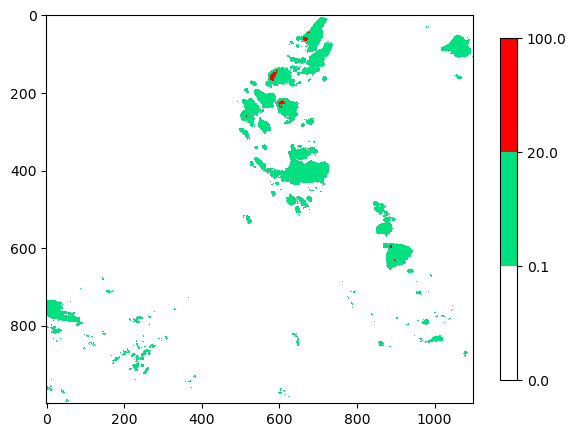

In [11]:
plt.figure(figsize=(6, 6))

plt.subplot(111)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, norm=norm)

plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.tight_layout()
plt.show()

# Hago un dispersograma de todas las bandas

In [ ]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
norm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(15, 15), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(imag_cal_list[0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[1].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('Banda 8')
plt.ylabel('Banda 9')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(imag_cal_list[2].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[3].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('Banda 10')
plt.ylabel('Banda 11')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(imag_cal_list[4].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[5].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 12')
plt.ylabel('Banda 13')

plt.subplot(3, 3, 4)

plt.hist2d(imag_cal_list[6].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[7].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 14')
plt.ylabel('Banda 15')


plt.subplot(3, 3, 5)

plt.hist2d(imag_cal_list[8].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[0].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 16')
plt.ylabel('Banda 8')


plt.subplot(3, 3, 6)

plt.hist2d(imag_cal_list[0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 8')
plt.ylabel('Banda 10')


plt.subplot(3, 3, 7)

plt.hist2d(imag_cal_list[1].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[4].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 9')
plt.ylabel('Banda 12')


plt.subplot(3, 3, 8)

plt.hist2d(imag_cal_list[2].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[6].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 10')
plt.ylabel('Banda 14')


plt.subplot(3, 3, 9)

plt.hist2d(imag_cal_list[4].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           imag_cal_list[8].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=256,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda 12')
plt.ylabel('Banda 16')


plt.tight_layout()
plt.show()

# Definicion de la funcion para analisis de componentes principales

In [36]:
len(imag_cal_list)

9

# Se grafican combinaciones RGB de las distintas bandas con opción de pasar a negativo (1-banda)

In [ ]:
combinaciones = [[0,1,2],[3,4,5],[6,7,8],[0,7,8],
                 [0,2,4],[1,3,8],[2,4,6],[3,4,6],
                 [0,3,6],[0,4,8],[1,3,7],[2,5,8]]

n=1

negativo_R = False
negativo_G = False
negativo_B = False

tercera_dim = 3

for i,j,k in combinaciones:
    
    RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, tercera_dim))
    
    print('Bandas:',i+8,j+8,k+8)
    RGBrec[:, :, 0] = imag_cal_list[i]
    RGBrec[:, :, 1] = imag_cal_list[j]
    RGBrec[:, :, 2] = imag_cal_list[k]
    
    title_markR = 'RN'
    title_markG = 'GN'
    title_markB = 'BN'
    
    if negativo_R:
        RGBrec[:, :, 0] = 1-imag_cal_list[i]
    if negativo_G:
        RGBrec[:, :, 1] = 1-imag_cal_list[j]
    if negativo_B:
        RGBrec[:, :, 2] = 1-imag_cal_list[k]

    # Aplicamos PCA a la imagen RGB recortada original (sin realzar!!!!)
    x_pca, eigen_vals, eigen_vecs = pca(RGBrec)

    # Hacemos un realce a las componentes principales para graficarlas (sólo para visualización!!!)
    # NOTA: Observe que la función realc() debe recibir un array 3D, y que x_pca es un array de dos 
    #       dimensiones (verifíquelo). Por esto tenemos que hacer antes un reshape a x_pca para llevarlo a las
    #       dimensiones adecuadas para aplicar la función.
    # x_pca_3d = np.reshape(x_pca, [..., ..., ...])
    x_pca_3d = np.reshape(x_pca, [inf_row-sup_row, inf_col-sup_col, tercera_dim])

    # Aplique un realce a x_pca_3d
    x_pca_3d_realzada = np.zeros_like(x_pca_3d)
    for l in range(tercera_dim):
        x_pca_3d_realzada[:, :, l] = realce(x_pca_3d[:, :, l], p=0.2)

    # Aplique un realce a x_pca_3d
    RGBrec_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, tercera_dim))
    for m in range(tercera_dim):
        RGBrec_realzada[:,:,m] = realce(RGBrec[:,:,m], p=0.2)

    plt.figure(figsize=(15, 6))

    plt.subplot(131)
    plt.imshow(RGBrec_realzada)
    plt.title("Imagen Original RGB realzada")

    plt.subplot(132)
    plt.imshow(x_pca_3d_realzada, cmap='jet')
    
    title_fig = str(n)
    plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+'\nComponentes principales realzada')
    
    if negativo_R:
        plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markR+'\nComponentes principales realzada')
        title_fig = title_markR+'_'+str(n)
    if negativo_G:
        plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markG+'\nComponentes principales realzada')
        title_fig = title_markG+'_'+str(n)
    if negativo_B:
        plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markB+'\nComponentes principales realzada')
        title_fig = title_markB+'_'+str(n)
    if negativo_R and negativo_G:
        plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markR+title_markG+'\nComponentes principales realzada')
        title_fig = title_markR+title_markG+'_'+str(n)
    if negativo_R and negativo_B:
        plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markR+title_markB+'\nComponentes principales realzada')
        title_fig = title_markR+title_markB+'_'+str(n)
    if negativo_B and negativo_G:
        plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markB+title_markG+'\nComponentes principales realzada')
        title_fig = title_markB+title_markG+'_'+str(n)
    if negativo_R and negativo_B and negativo_G:
        plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+title_markR+title_markB+title_markG+'\nComponentes principales realzada')
        title_fig = title_markR+title_markB+title_markG+'_'+str(n)
    
    plt.subplot(133)
    plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
               cmap=cmap, vmin=0, vmax=100)
    plt.title("Producto QPE")
    # plt.colorbar(shrink=.2)
    
    plt.tight_layout()
    #plt.savefig('/home/msuarez/GOES_16_TF/Figuras/Figura_'+title_fig+'.png', dpi=200)
    
    n=n+1
    
    plt.show()

In [ ]:
# i = 8-8
# j = 10-8
# k = 11-8
# p = 13-8
# q = 14-8
# o = 16-8

# dims = 6

# RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, dims))

# RGBrec[:, :, 0] = imag_cal_list[i]
# RGBrec[:, :, 1] = imag_cal_list[j]
# RGBrec[:, :, 2] = imag_cal_list[k]
# RGBrec[:, :, 3] = imag_cal_list[p]
# RGBrec[:, :, 4] = imag_cal_list[q]
# RGBrec[:, :, 5] = imag_cal_list[o]

# # Aplicamos PCA a la imagen RGB recortada original (sin realzar!!!!)
# x_pca, eigen_vals, eigen_vecs = pca(RGBrec)

# # Hacemos un realce a las componentes principales para graficarlas (sólo para visualización!!!)
# # NOTA: Observe que la función realc() debe recibir un array 3D, y que x_pca es un array de dos 
# #       dimensiones (verifíquelo). Por esto tenemos que hacer antes un reshape a x_pca para llevarlo a las
# #       dimensiones adecuadas para aplicar la función.
# # x_pca_3d = np.reshape(x_pca, [..., ..., ...])
# x_pca_3d = np.reshape(x_pca, [inf_row-sup_row, inf_col-sup_col, dims])

# # Aplique un realce a x_pca_3d
# x_pca_3d_realzada = np.zeros_like(x_pca_3d)
# for l in range(dims):
#     x_pca_3d_realzada[:, :, l] = realce(x_pca_3d[:, :, l])

# # Aplique un realce a x_pca_3d
# RGBrec_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, dims))
# for m in range(dims):
#     RGBrec_realzada[:,:,m] = realce(RGBrec[:,:,m])

# plt.figure(figsize=(15, 6))

# print('x_pca_3d_realzada.shape',x_pca_3d_realzada.shape)

# plt.subplot(121)
# plt.imshow(x_pca_3d_realzada[:,:,0], cmap='coolwarm')
# plt.title('Bandas:'+str(i+8)+' '+str(j+8)+' '+str(k+8)+' '+'\nComponentes principales realzada')

# plt.subplot(122)
# plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
#            cmap=cmap, vmin=0, vmax=100)
# plt.title("Producto QPE")
# # plt.colorbar(shrink=.2)

# plt.tight_layout()
# #plt.savefig('/home/msuarez/GOES_16_TF/Figuras/Figura_'+title_fig+'.png', dpi=200)

# plt.show()

# Nos quedamos con una potencial combinacion RGB para detectar areas de lluvias debiles y fuertes

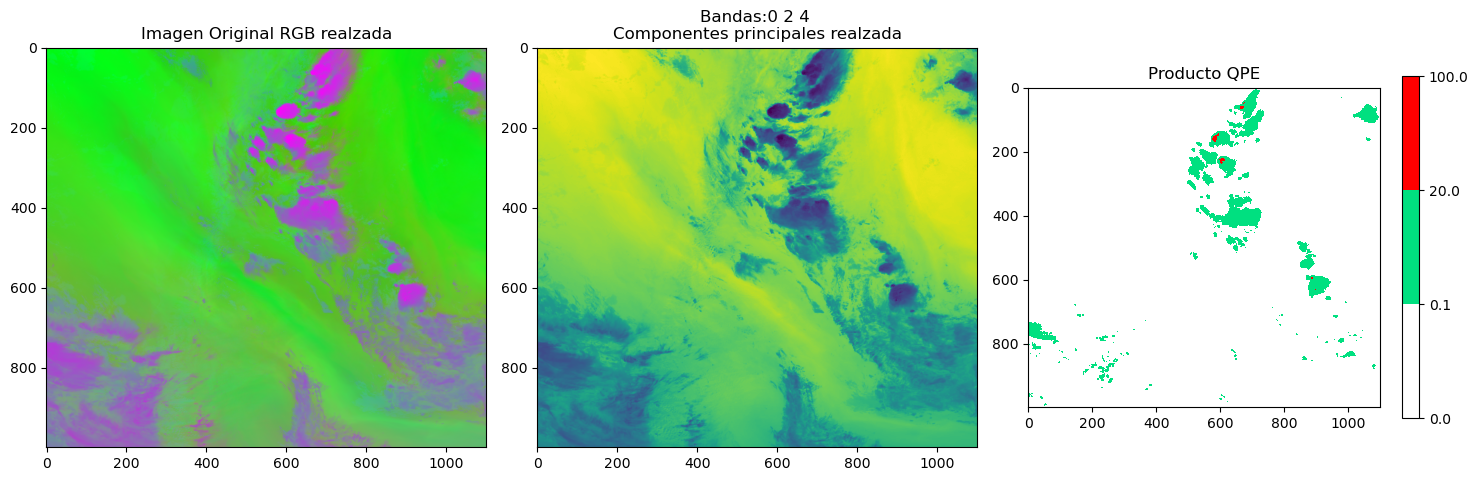

In [20]:
RGBrec = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

bandaR = 8-8
bandaG = 10-8
bandaB = 12-8

RGBrec[:, :, 0] = 1-imag_cal_list[bandaR]
RGBrec[:, :, 1] = imag_cal_list[bandaG]
RGBrec[:, :, 2] = 1-imag_cal_list[bandaB]

# bandaR = 11-8
# bandaG = 12-8
# bandaB = 14-8

# RGBrec[:, :, 0] = 1-imag_cal_list[bandaR]
# RGBrec[:, :, 1] = imag_cal_list[bandaG]
# RGBrec[:, :, 2] = 1-imag_cal_list[bandaB]

# Aplicamos PCA a la imagen RGB recortada original (sin realzar!!!!)
x_pca, eigen_vals, eigen_vecs = pca(RGBrec)

# Hacemos un realce a las componentes principales para graficarlas (sólo para visualización!!!)
# NOTA: Observe que la función realc() debe recibir un array 3D, y que x_pca es un array de dos 
#       dimensiones (verifíquelo). Por esto tenemos que hacer antes un reshape a x_pca para llevarlo a las
#       dimensiones adecuadas para aplicar la función.
# x_pca_3d = np.reshape(x_pca, [..., ..., ...])
x_pca_3d = np.reshape(x_pca, [inf_row-sup_row, inf_col-sup_col, 3])

# Aplique un realce a x_pca_3d
x_pca_3d_realzada = np.zeros_like(x_pca_3d)
for l in range(3):
    x_pca_3d_realzada[:, :, l] = realce(x_pca_3d[:, :, l], p=0.01)

# Aplique un realce a x_pca_3d
RGBrec_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))
for m in range(3):
    RGBrec_realzada[:,:,m] = realce(RGBrec[:,:,m], p=0.01)

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(RGBrec_realzada)
plt.title("Imagen Original RGB realzada")

plt.subplot(132)
plt.imshow(x_pca_3d_realzada[:,:,0])

plt.title('Bandas:'+str(bandaR)+' '+str(bandaG)+' '+str(bandaB)+' '+'\nComponentes principales realzada')


plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, norm=norm)
plt.title("Producto QPE")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.tight_layout()

plt.show()

In [148]:
x_pca_3d_realzada.shape

(400, 500, 3)

# Hacemos el dispersograma de la combinacion anterior

In [ ]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
norm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(15, 15), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(RGBrec_realzada[:, :, 0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           RGBrec_realzada[:, :, 1].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('Banda R')
plt.ylabel('Banda G')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(RGBrec_realzada[:, :, 0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           RGBrec_realzada[:, :, 2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('Banda R')
plt.ylabel('Banda B')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(RGBrec_realzada[:, :, 1].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           RGBrec_realzada[:, :, 2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda G')
plt.ylabel('Banda B')


plt.tight_layout()
plt.show()

# Hacemos el dispersograma del analisis de componentes principales de la combinacion RGB anterior

In [ ]:
import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
norm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(15, 15), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(x_pca_3d_realzada[:, :, 0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 1].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('Banda R')
plt.ylabel('Banda G')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(x_pca_3d_realzada[:, :, 0].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('Banda R')
plt.ylabel('Banda B')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(x_pca_3d_realzada[:, :, 1].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 2].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=150,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=norm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda G')
plt.ylabel('Banda B')


plt.tight_layout()
plt.show()

# Areas de lluvias intensas

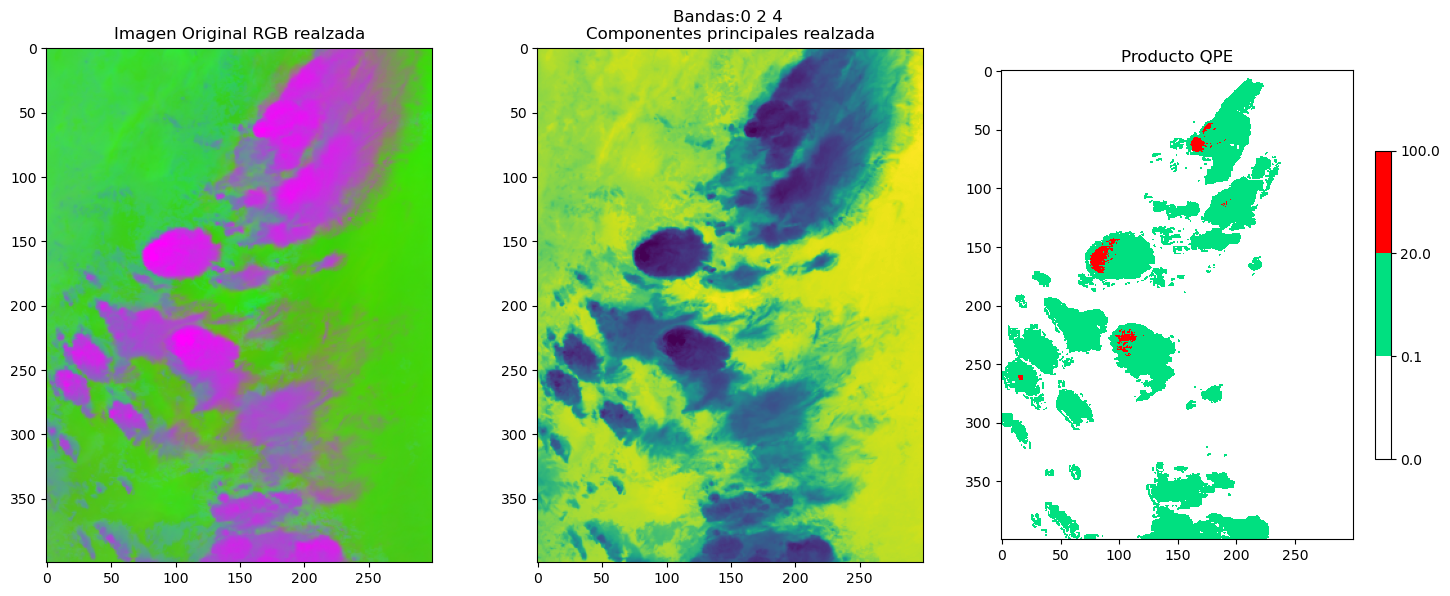

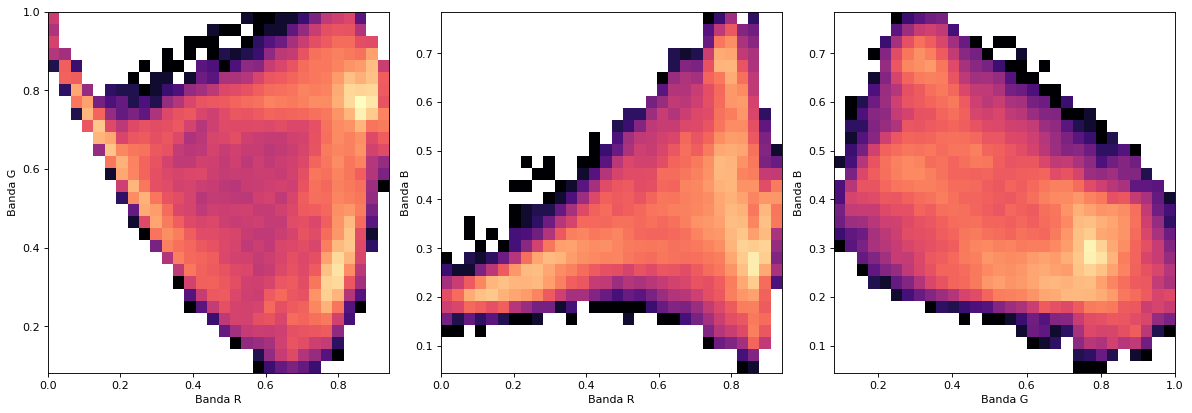

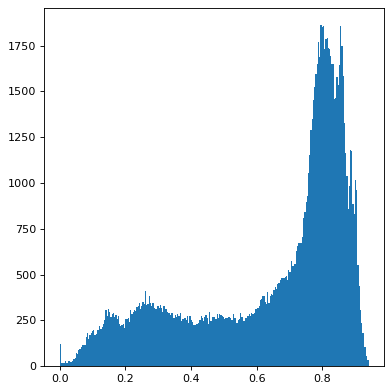

In [13]:
xmin = 500
xmax = 800
ymin = 0
ymax = 400

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(RGBrec_realzada[ymin:ymax, xmin:xmax, :])
plt.title("Imagen Original RGB realzada")

plt.subplot(132)
plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
plt.title('Bandas:'+str(bandaR)+' '+str(bandaG)+' '+str(bandaB)+' '+'\nComponentes principales realzada')


plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],
           cmap=cmap, norm=norm)
plt.title("Producto QPE")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.tight_layout()

plt.show()


import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(15, 15), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 1][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('Banda R')
plt.ylabel('Banda G')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 2][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('Banda R')
plt.ylabel('Banda B')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(x_pca_3d_realzada[:, :, 1][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 2][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda G')
plt.ylabel('Banda B')


plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5), dpi=80)
plt.subplot(1, 1, 1)
plt.hist(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), bins=250)
#plt.xlim(0,0.1)
plt.tight_layout()
plt.show()

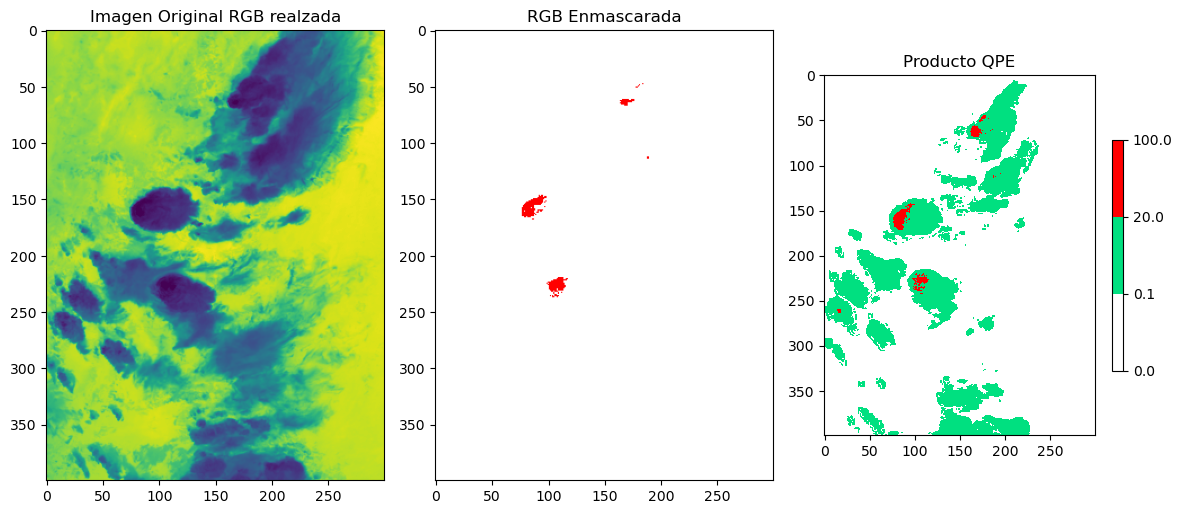

In [14]:
x_pca_realzada_copy = np.copy(x_pca_3d_realzada[ymin:ymax, xmin:xmax, :])

lluvia_intensa =  (x_pca_realzada_copy[:,:,0] < 0.05) 
#(x_pca_realzada_copy[:,:,1] > 0.7) * (x_pca_realzada_copy[:,:,2] > 0.25) * (x_pca_realzada_copy[:,:,2] < 0.35)

img_enmascarada = np.ones_like(x_pca_realzada_copy)
#img_filtrada = np.copy(x_pca_3d_realzada[:,:,:])

img_enmascarada[lluvia_intensa,1:3] = 0
img_enmascarada[lluvia_intensa,0]   = 1

##################################################################################################

plt.figure(figsize=(12, 8))

plt.subplot(131)
plt.imshow(x_pca_realzada_copy[:, :, 0])
plt.title("Imagen Original RGB realzada")

plt.subplot(132)
plt.imshow(img_enmascarada)
plt.title('RGB Enmascarada')

plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],
           cmap=cmap, norm=norm)
plt.title("Producto QPE")
plt.colorbar(shrink=.3, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)


plt.tight_layout()

plt.show()

# Areas de lluvias ligeras

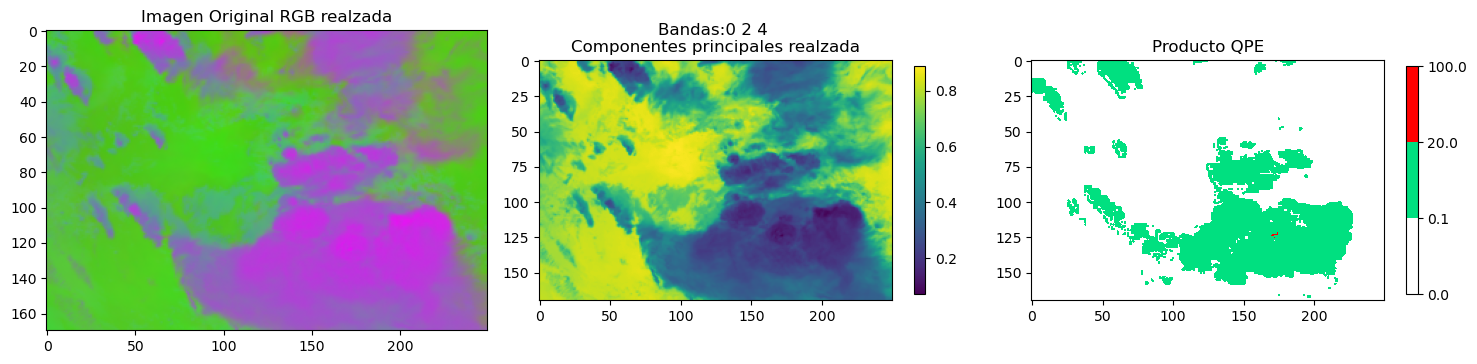

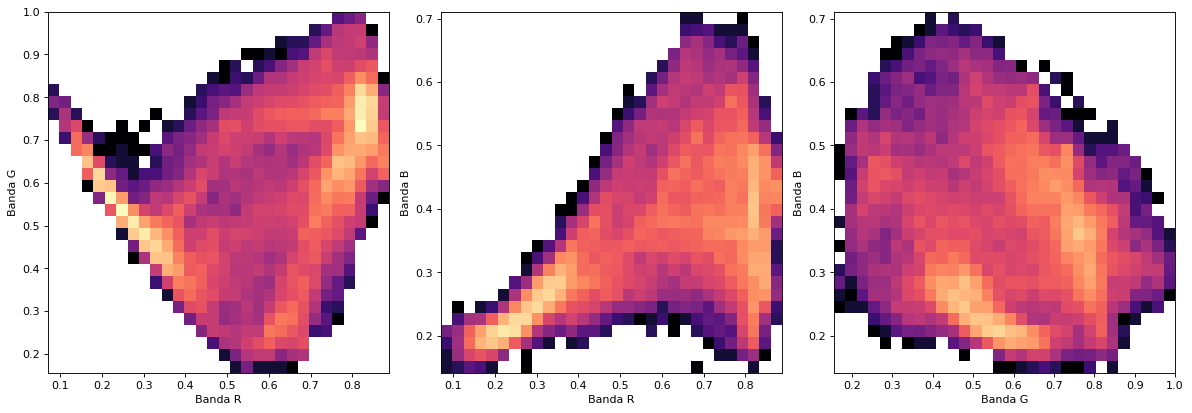

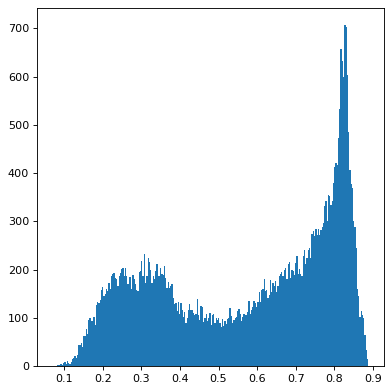

In [15]:
xmin = 500
xmax = 750
ymin = 280
ymax = 450

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(RGBrec_realzada[ymin:ymax, xmin:xmax, :])
plt.title("Imagen Original RGB realzada")

plt.subplot(132)
plt.imshow(x_pca_3d_realzada[ymin:ymax, xmin:xmax, 0])
plt.colorbar(shrink=.4)
plt.title('Bandas:'+str(bandaR)+' '+str(bandaG)+' '+str(bandaB)+' '+'\nComponentes principales realzada')


plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],
           cmap=cmap, norm=norm)
plt.title("Producto QPE")
plt.colorbar(shrink=.4, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)


plt.tight_layout()

plt.show()


import matplotlib

# Creamos un objeto para normalizar las gráficas de forma logarítmica
lognorm = matplotlib.colors.LogNorm()

# Creamos la figura
plt.figure(figsize=(15, 15), dpi=80)

# Graficamos el dispersograma de las bandas 1 y 2
plt.subplot(3, 3, 1)

plt.hist2d(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 1][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 1], [0, 1]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 8 y 9')
plt.xlabel('Banda R')
plt.ylabel('Banda G')

# Graficamos el dispersograma de las bandas 4 y 5
plt.subplot(3, 3, 2)

plt.hist2d(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 2][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 10 y 11')
plt.xlabel('Banda R')
plt.ylabel('Banda B')

# Graficamos el dispersograma de las bandas 6 y 3
plt.subplot(3, 3, 3)

plt.hist2d(x_pca_3d_realzada[:, :, 1][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje x (debe ser un vector undimensional)
           x_pca_3d_realzada[:, :, 2][ymin:ymax, xmin:xmax].flatten(), # Coordenadas del eje y (debe ser un vector undimensional)
           bins=30,                                                # Cantidad de bines para la gráfica
           #range=[[0, 0.4], [0, 0.4]],                              # Limitamos el rango de visualización
           norm=lognorm, cmap='magma')                                               # Aplicamos la norma logarítmica
#plt.title('Dispersograma Bandas 12 y 13')
plt.xlabel('Banda G')
plt.ylabel('Banda B')


plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5), dpi=80)
plt.subplot(1, 1, 1)
plt.hist(x_pca_3d_realzada[:, :, 0][ymin:ymax, xmin:xmax].flatten(), bins=250)
#plt.xlim(0,0.1)
plt.tight_layout()
plt.show()

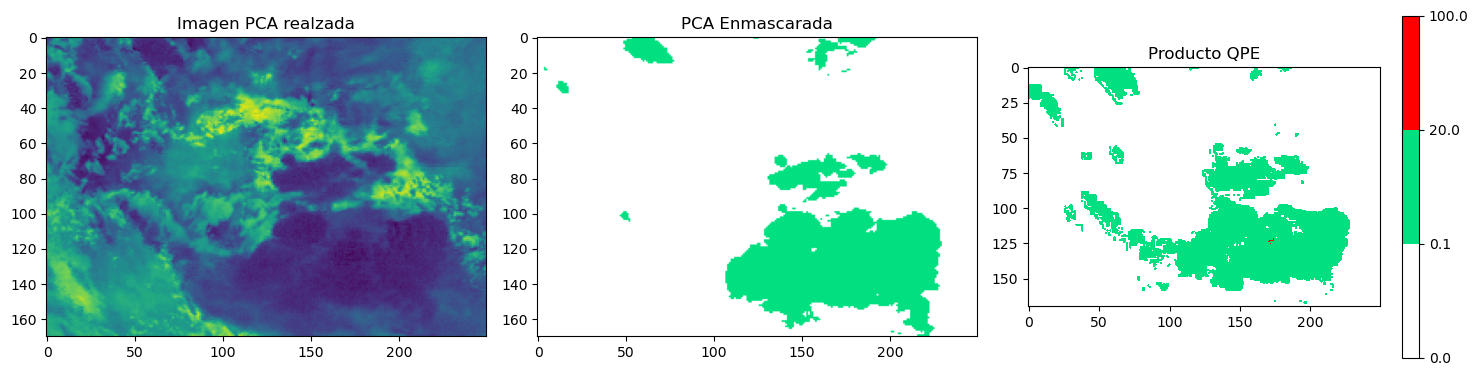

In [27]:
x_pca_realzada_copy = np.copy(x_pca_3d_realzada[ymin:ymax, xmin:xmax, :])

lluvia_ligera =  (x_pca_realzada_copy[:,:,0] >= 0.05) * (x_pca_realzada_copy[:,:,0] < 0.3)
#(x_pca_realzada_copy[:,:,1] > 0.4) * (x_pca_realzada_copy[:,:,2] < 0.2)

img_enmascarada = np.ones_like(x_pca_realzada_copy)
#img_filtrada = np.copy(x_pca_3d_realzada[:,:,:])

img_enmascarada[lluvia_ligera,0] = 0
img_enmascarada[lluvia_ligera,2] = 0.501960813999176
img_enmascarada[lluvia_ligera,1] = 0.8784313797950745
##################################################################################################

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(x_pca_realzada_copy[:,:,2])
plt.title("Imagen PCA realzada")

plt.subplot(132)
plt.imshow(img_enmascarada)
plt.title('PCA Enmascarada')

plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col][ymin:ymax, xmin:xmax],
           cmap=cmap, norm=norm)
plt.title("Producto QPE")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)


plt.tight_layout()
plt.show()

# Combinacion de areas de lluvias fuertes y ligeras

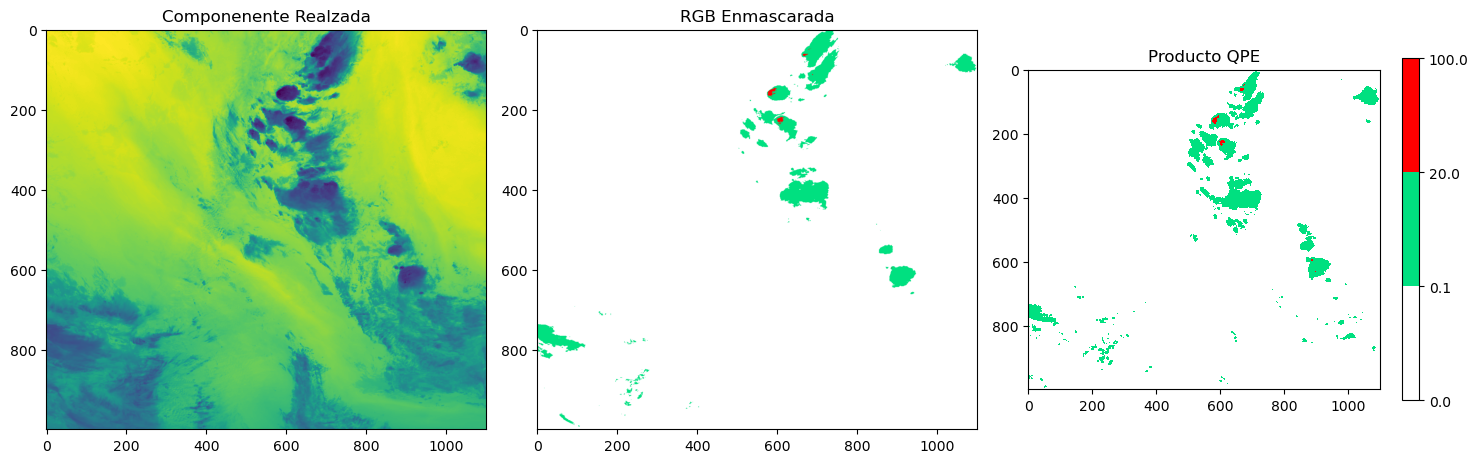

In [28]:
#lluvia_ligera =  (x_pca_3d_realzada[:,:,1] < 0.7) *\
#(x_pca_3d_realzada[:,:,1] > 0.4) * (x_pca_3d_realzada[:,:,2] < 0.2)

#lluvia_intensa =  (x_pca_3d_realzada[:,:,0] < 0.025) * (x_pca_3d_realzada[:,:,1] > 0.9) *\
#(x_pca_3d_realzada[:,:,2] < 0.025)

lluvia_ligera =  (x_pca_3d_realzada[:,:,0] >= 0.05) * (x_pca_3d_realzada[:,:,0] < 0.3)
lluvia_intensa =  (x_pca_3d_realzada[:,:,0] < 0.05) 

img_enmascarada = np.ones_like(x_pca_3d_realzada)
#img_filtrada = np.copy(x_pca_3d_realzada[:,:,:])

img_enmascarada[lluvia_intensa,1:3] = 0
img_enmascarada[lluvia_intensa,0]   = 1

img_enmascarada[lluvia_ligera,0] = 0
img_enmascarada[lluvia_ligera,2] = 0.501960813999176
img_enmascarada[lluvia_ligera,1] = 0.8784313797950745

##################################################################################################

plt.figure(figsize=(15, 6))

plt.subplot(131)
plt.imshow(x_pca_3d_realzada[:,:,0])
plt.title("Componenente Realzada")

plt.subplot(132)
plt.imshow(img_enmascarada)
plt.title('RGB Enmascarada')

plt.subplot(133)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, norm=norm)
plt.title("Producto QPE")
plt.colorbar(shrink=.6, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

plt.tight_layout()

plt.show()